# Analyse du 21/03/2025

In [13]:
import sys
import os
import os.path
import urllib.request
from pathlib import Path

import numpy as np
from scipy.ndimage import gaussian_filter, label, sum as ndi_sum

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import NDData
from astropy.coordinates import SkyCoord
from astropy.visualization import AsymmetricPercentileInterval

import sunpy.map
from sunpy.map import Map
from sunpy.coordinates import frames
from sunpy.physics.differential_rotation import solar_rotate_coordinate
from sunpy.visualization.colormaps import color_tables as ct

import pfsspy
import pfsspy.tracing as tracing
from pfsspy.sample_data import get_gong_map

from saffron.postprocessing import SPICEL3Raster
from saffron.utils import normit, get_coord_mat
from euispice_coreg.hdrshift.alignment import Alignment
from euispice_coreg.plot.plot import PlotFunctions
from euispice_coreg.utils.Util import AlignCommonUtil
from getmap import to_submap
from shapely.geometry import Point, Polygon

module_path = os.path.abspath('/home/wmouici/stage/spice-line-fits/linefit_modules')
sys.path.append(module_path)

from linefit_storage import (
    linefit_window_raws, iterdict, linefits,
    write_spice_linefit_file, read_spice_linefit_file,
    create_linefit_window, update_fits)
from skew_parameter_search import simple_lls, detrend_dopp


In [14]:
#Check the SOOP of the raster
path_list_2024 = [r"/archive/SOLAR-ORBITER/SPICE/fits/level2/2025/03/21/solo_L2_spice-n-ras_20250321T040142_V04_318767203-000.fits",]

for name in path_list_2024:
    hdul = fits.open(name)
    print(hdul[0].header['STUDY'])

SCI_COMPO-COOLHOT_SC_SL04_60.0S_FF


### Radiance maps

In [15]:
# Replace the folder_path below with the path to YOUR OWN raster results
raster = SPICEL3Raster(folder_path="../run_saffron/saffron_run_results_corrige/solo_L2.5_spice-n-ras_20250321T040142_V04_318767203-000_0600")
radiance_mg = raster.find_line(706).get_map("rad",remove_dumbells=True)
radiance_n = raster.find_line(765).get_map("rad",remove_dumbells=True)
radiance_ne8 = raster.find_line(770).get_map("rad",remove_dumbells=True)

2025-08-25 15:57:12 - sunpy - WARNING: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.


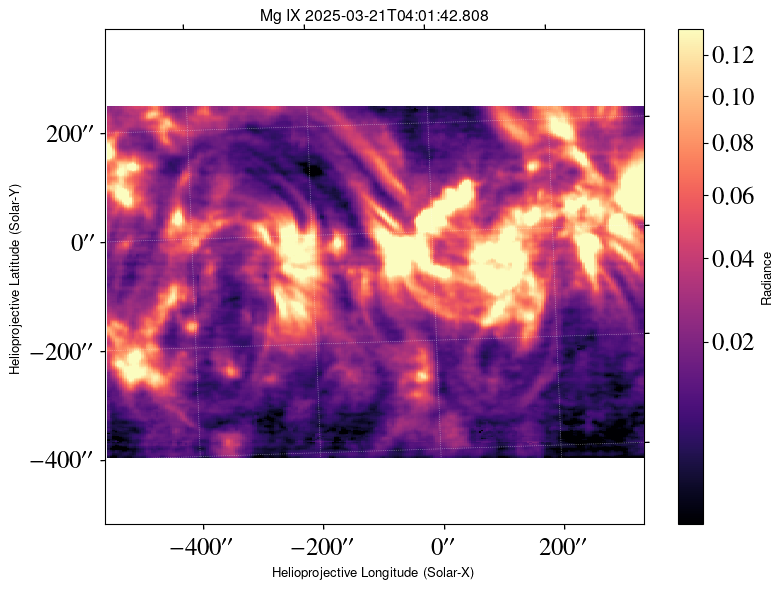

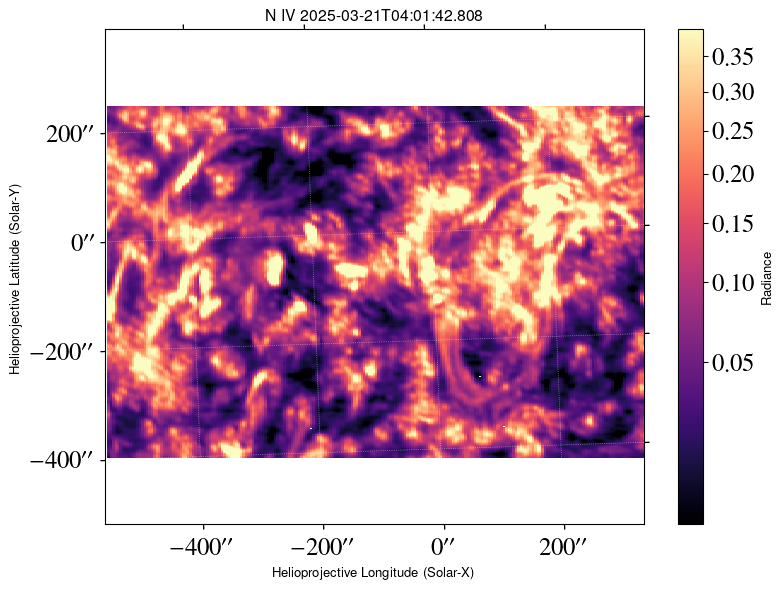

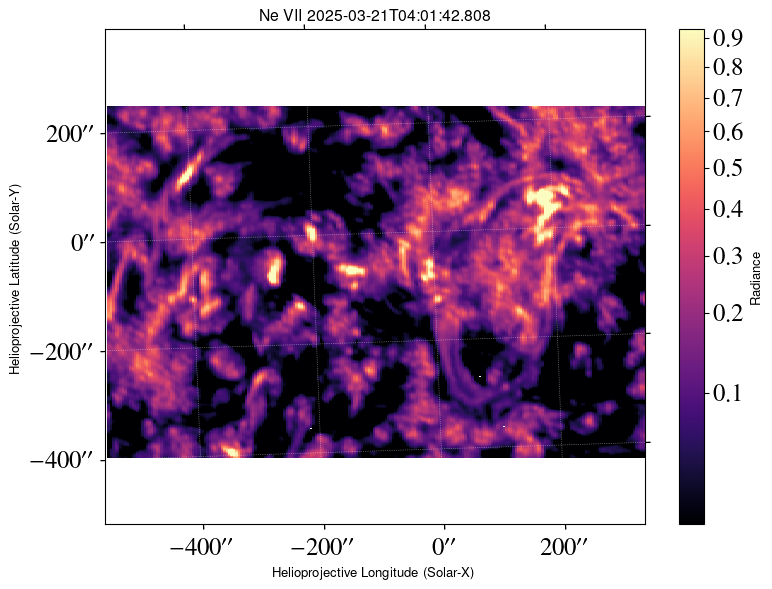

In [16]:
# Normalisation pour un bon contraste
norm = normit(radiance_mg.data, AsymmetricPercentileInterval(1, 95))

plt.figure(figsize=(8, 6))
radiance_mg.plot(norm=norm, cmap='magma')
plt.title(f"Mg IX {radiance_mg.meta.get('date-obs', 'Date inconnue')}", fontsize=12)
plt.colorbar(label="Radiance")
plt.tight_layout()
#plt.savefig('/home/wmouici/stage/data/radiance_mg_2103.pdf')
plt.show()

norm = normit(radiance_n.data, AsymmetricPercentileInterval(1, 95))

plt.figure(figsize=(8, 6))
radiance_n.plot(norm=norm, cmap='magma')
plt.title(f"N IV {radiance_n.meta.get('date-obs', 'Date inconnue')}", fontsize=12)
plt.colorbar(label="Radiance")
plt.tight_layout()
plt.show()

norm = normit(radiance_ne8.data, AsymmetricPercentileInterval(1, 95))

plt.figure(figsize=(8, 6))
radiance_n.plot(norm=norm, cmap='magma')
plt.title(f"Ne VII {radiance_ne8.meta.get('date-obs', 'Date inconnue')}", fontsize=12)
plt.colorbar(label="Radiance")
#plt.savefig('/home/wmouici/stage/data/radiance_ne8_2103.pdf')
plt.tight_layout()
plt.show()

### Bias FIP maps

In [17]:
#Make sure to download CHIANTI_10.1_database
os.environ["XUVTOP"] = "/home/wmouici/Downloads/CHIANTI_10.1_database"

LFLines = (('s_4', 750), ('s_5', 786))
HFLines = (('n_4', 765.15), ('n_3', 991.59))

/home/wmouici/envs/SAFFRON/lib/python3.11/site-packages/fiplcr/specline/specline.py:116: UserWarning: 0 in interpolated DEM: temperature probably out of range of CHIANTI DEM file
  warnings.warn('0 in interpolated DEM: temperature probably out of range of CHIANTI DEM file')


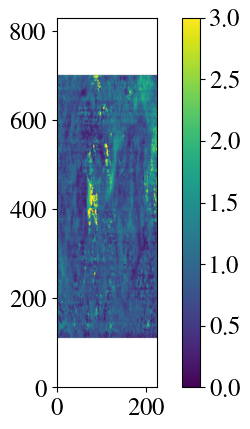

2025-08-25 16:03:17 - sunpy - WARNING: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.


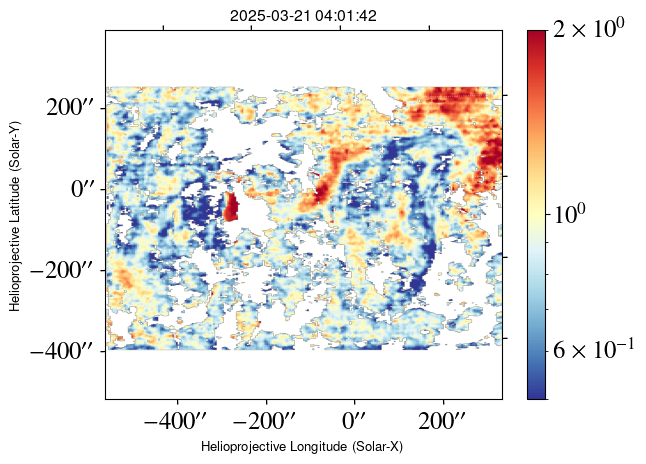

In [18]:
threshold = 0.5

raster.gen_compo_LCR(LFLines=LFLines, HFLines=HFLines)

fip_data = raster.FIP.copy()
fip_err = raster.FIP_err.copy()
mask = fip_err > threshold
masked_fip = np.ma.array(fip_data, mask=mask)
fip_map = sunpy.map.Map(masked_fip, raster.FIP_header)
fip_map.plot_settings = {
    "cmap": "RdYlBu_r",
    "norm": plt.matplotlib.colors.LogNorm(1 / 2, 2),
    "aspect": "auto",
}
fip_map.peek()

### Bias fip contours on bias fip maps on radiance and on FSI maps

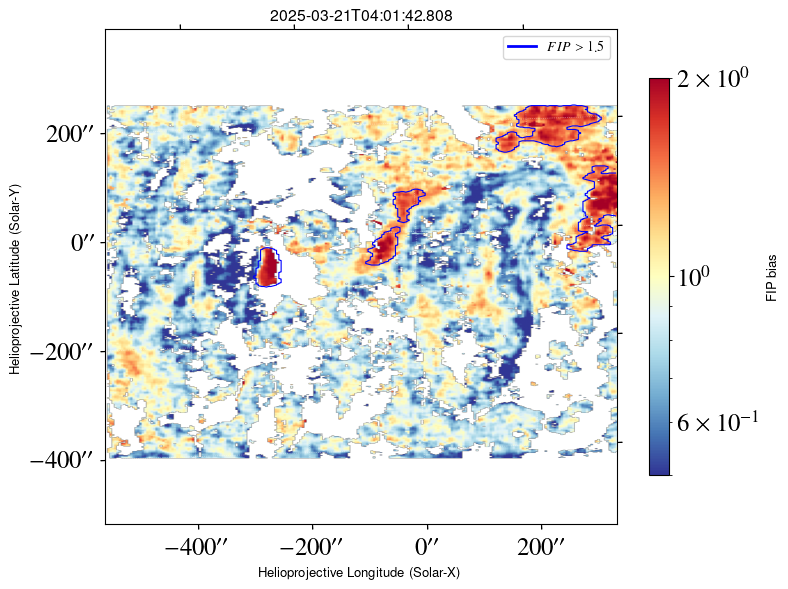

In [19]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection=fip_map)

norm = colors.LogNorm(0.5, 2)
fip_map.plot_settings['aspect'] = 'auto'
fip_map.plot(axes=ax, norm=norm, cmap="RdYlBu_r")
im = ax.images[0]

masked_data = masked_fip.squeeze()
mask = (~masked_data.mask) & (masked_data.data > 1.5)
mask = mask.astype(float)

smoothed = gaussian_filter(mask, sigma=2)


dense_regions = smoothed > 0.2

label_regions, nb = label(dense_regions)
region_sizes = ndi_sum(dense_regions, label_regions, index=np.arange(1, nb + 1))

min_size = 400
mask_clean = np.zeros_like(dense_regions)
for label_id, size in zip(range(1, nb + 1), region_sizes):
    if size >= min_size:
        mask_clean[label_regions == label_id] = 1

contours= ax.contour(mask_clean, levels=[0.5], colors='blue', linewidths=0.8, transform=ax.get_transform('pixel'))


custom_line = Line2D([0], [0], color='blue', lw=2, label=r'$FIP > 1.5$')
ax.legend(handles=[custom_line], loc='upper right')

cbar = plt.colorbar(im, ax=ax, pad=0.05, shrink=0.8)
cbar.set_label("FIP bias")
ax.set_title(f"{fip_map.meta.get('date-obs', 'Date inconnue')}")
plt.tight_layout()
#plt.savefig('/home/wmouici/stage/data/bias_fip_2103.pdf')
plt.show()

In [20]:
arcsec_contours = []
for level_segs in contours.allsegs: 
    for seg in level_segs:        
        if len(seg) == 0:
            continue
        world_coords = fip_map.pixel_to_world(seg[:, 0]*u.pixel, seg[:, 1]*u.pixel)
        arcsec_contours.append(world_coords)

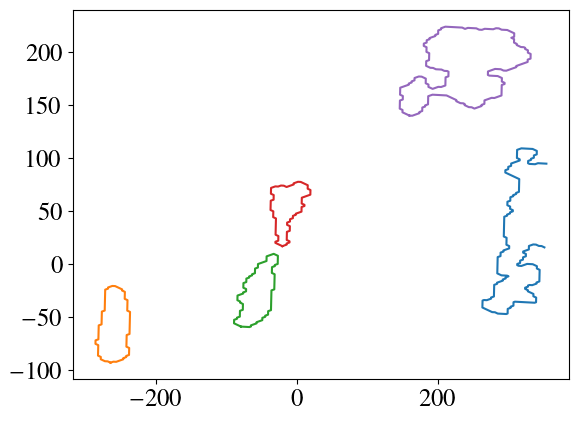

In [21]:
for contour in arcsec_contours:
    plt.plot(contour.Tx.to_value(u.arcsec), contour.Ty.to_value(u.arcsec))


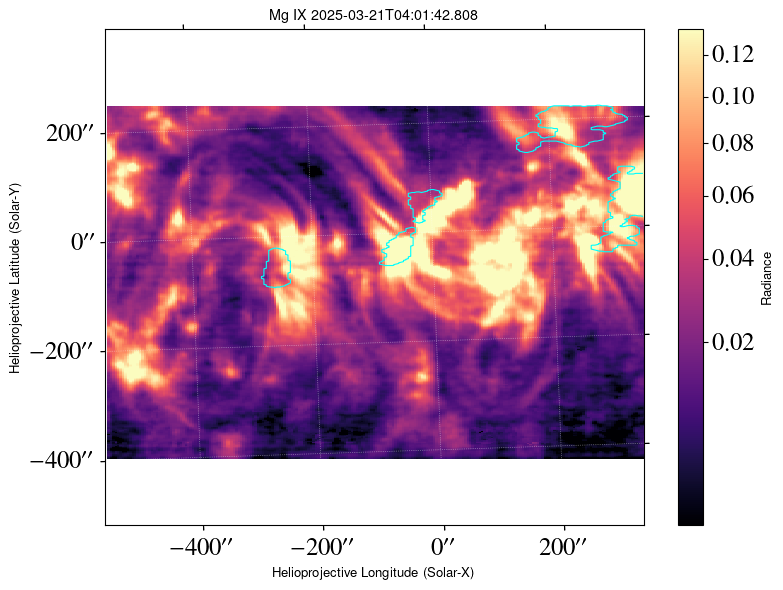

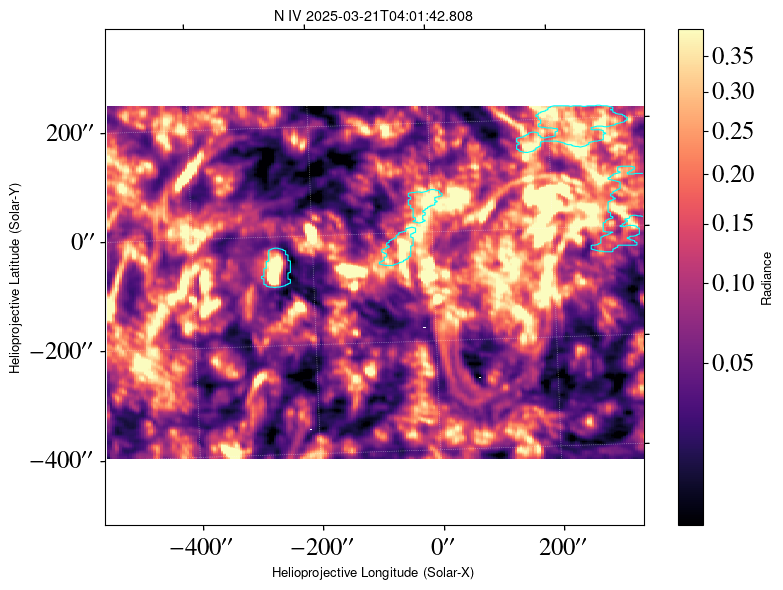

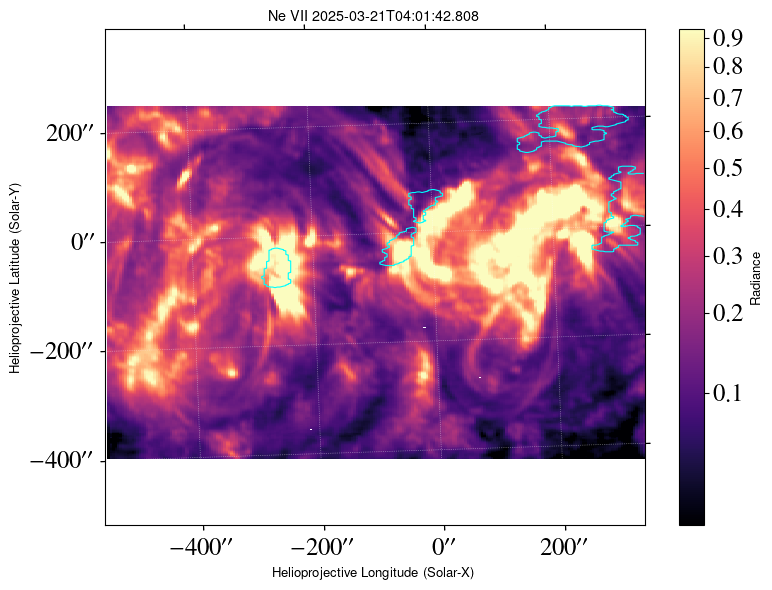

In [22]:
rad_map_mg = radiance_mg
norm = normit(rad_map_mg.data, AsymmetricPercentileInterval(1, 95))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection=rad_map_mg)
rad_map_mg.plot(norm=norm, cmap='magma', axes=ax)

ax.contour(mask_clean, levels=[0.5], colors='cyan', linewidths=0.8, transform=ax.get_transform('pixel'))

ax.set_title(f" Mg IX {rad_map_mg.meta.get('date-obs')}", fontsize=11)
plt.colorbar(ax.images[0], ax=ax, label="Radiance")
plt.tight_layout()
plt.show()

rad_map_n = radiance_n
norm = normit(rad_map_n.data, AsymmetricPercentileInterval(1, 95))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection=rad_map_n)
rad_map_n.plot(norm=norm, cmap='magma', axes=ax)

ax.contour(mask_clean, levels=[0.5], colors='cyan', linewidths=0.8, transform=ax.get_transform('pixel'))

ax.set_title(f" N IV {rad_map_n.meta.get('date-obs')}", fontsize=11)
plt.colorbar(ax.images[0], ax=ax, label="Radiance")
plt.tight_layout()
plt.show()

rad_map_ne8 = radiance_ne8
norm = normit(rad_map_ne8.data, AsymmetricPercentileInterval(1, 95))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection=rad_map_ne8)
rad_map_ne8.plot(norm=norm, cmap='magma', axes=ax)


ax.contour(mask_clean, levels=[0.5], colors='cyan', linewidths=0.8, transform=ax.get_transform('pixel'))
ax.set_title(f" Ne VII {rad_map_ne8.meta.get('date-obs')}", fontsize=11)
plt.colorbar(ax.images[0], ax=ax, label="Radiance")
plt.tight_layout()
plt.show()



### Doppler maps

In [23]:
# # This function, simple_lls, performs a Simple Linear Least Squares (LLS) fit of a linear model 
# # (a sum of basis functions with unknown coefficients) to given data with uncertainties.


# # The SPICE Doppler tend to contain a trend across the image field.
# # Since this will impact the Doppler variance we use to determine which
# # shift is optimal we fit linear trends in x and y and remove them:
def detrend_dopp(dopp, dopp_err): # Remove linear spatial trend in x and y from Doppler
    snr_th = np.abs(dopp) > 2 * np.abs(dopp_err)
    mask = snr_th & (dopp_err > 0)

    nx, ny = dopp.shape
    x0 = np.ones((nx, ny))
    x1, x2 = np.indices((nx, ny))
    x1 = x1 - 0.5 * nx
    x2 = x2 - 0.5 * ny

    mask &= ~np.isnan(dopp)

    cvec = simple_lls(dopp[mask], dopp_err[mask], [x0[mask], x1[mask], x2[mask]])
    dopp_detrend = dopp - x1 * cvec[1] - x2 * cvec[2]
    return dopp_detrend

# def doppler_nddata_to_map(linefit_nddata, err_thold=0.025, conv_factor=1.0, unit=None):
# def doppler_plot(dopp_err_thold=0.025,  doppmin=-0.1, doppmax=0.1, ):
def doppler_map_from_nddata(linefit_nddata, dopp_err_thold=0.025, err_thold=0.025,
                             xmin=0, xmax=None, ymin=0, ymax=None,
                             conv_factor=1.0, unit=None):

    if not isinstance(linefit_nddata, NDData):
        raise TypeError("Expected an NDData object")

    # Extract data
    dopp_data = linefit_nddata.data.squeeze()
    dopp_err = linefit_nddata.uncertainty.array.squeeze()
    metadat = linefit_nddata.meta

    # Default bounds if not specified
    if xmax is None:
        xmax = dopp_data.shape[0]
    if ymax is None:
        ymax = dopp_data.shape[1]

    # Mask on valid errors
    dopp_err_mask = (dopp_err > 0) & (dopp_err < err_thold)

    # Detrend and center the Doppler values
    dopp_detrend = detrend_dopp(dopp_data, dopp_err)
    dopp_center = np.median(dopp_detrend[dopp_err_mask])
    dopp_err_falloff = (dopp_err > 0) * np.clip(err_thold / dopp_err, None, 1) ** 2

    # Apply error-based masking (clip noisy features)
    dopp_errmod = dopp_detrend - dopp_center
    dopp_errmod = np.sign(dopp_errmod) * np.clip(np.abs(dopp_errmod) - np.abs(1.0 * dopp_err), 0, None) + dopp_center

    # Convert units if needed
    if unit is not None:
        dopp_center *= conv_factor
        dopp_errmod *= conv_factor
    else:
        unit = metadat.get('BUNIT', 'unknown')
   # Slice the desired subregion
    submap_data = dopp_errmod[xmin:xmax, ymin:ymax]

    # Build WCS header
    header = metadat.copy()
    header['CUNIT1'] = header.get('CUNIT1', 'arcsec')
    header['CUNIT2'] = header.get('CUNIT2', 'arcsec')
    header['BUNIT'] = unit

    # Adjust CRPIX to account for cropping
    header['NAXIS1'] = submap_data.shape[0]
    header['NAXIS2'] = submap_data.shape[1]
    header['CRPIX1'] -= xmin
    header['CRPIX2'] -= ymin

    wcs = WCS(header)
    doppler_map = sunpy.map.Map(submap_data.T, header)  # Transpose for correct orientation

    return doppler_map

### Make sure to have the corrected right psf file

In [24]:
# Path to your FITS file
filename = "../doppler_map/solo_L2_spice-n-ras_20250321T040142_V06_318767203-000psfcorrected_linefits_2.fits"

# from spice_line_fits import read_spice_linefit_file

linefits = read_spice_linefit_file(filename)
line_nd = linefits['Ne VIII 780']['Ne VIII 780']['centers']   # or whatever line you are using 
doppler_map = doppler_map_from_nddata(line_nd)

doppler_map.peek()  # Quick look

# Calculate conversion factor for velocity (Å to km/s)
λ = line_nd.meta['CRVAL3'] * 10  # # Rest wavelength in Angstroms
print(λ)
from astropy.constants import c
# Compute c in km/s
c_kms = c.to('km/s').value  # ≈ 299792.458 km/s

# Conversion factor (km/s per Angstrom)
conv_factor = c_kms / λ
print(f"Conversion factor: {conv_factor:.4f} km/s per Angstrom")

# Get Doppler velocity map
dopp_map = doppler_map_from_nddata(line_nd, conv_factor=conv_factor, unit='km/s')

# print(dopp_map.unit)  # Should report 'km/s'
# print(np.nanmin(dopp_map.data), np.nanmax(dopp_map.data))  # Check velocity range

# print(dopp_map.data)

dopp_map.plot(cmap='RdBu_r', 
                    #  vmin=-20,
                    #  vmax=20, 
                     aspect = 0.6)


# lambda_0 = 976.943963507  # Carbon III rest wavelength
#lambda_0 = 1031.79506351  # O VI rest wavelength
lambda_0  = 780   # Ne VIII

# Check if data is absolute or already Δλ
if np.nanmean(line_nd.data) > lambda_0 / 2:
    print("Data looks like absolute wavelengths — subtracting rest λ")
    dopp_shift = line_nd.data - lambda_0
else:
    print("Data looks like wavelength shifts already — using as-is")
    dopp_shift = line_nd.data

# Compute conv factor (km/s per Å)
from astropy.constants import c
c_kms = c.to('km/s').value
conv_factor = c_kms / lambda_0

# Wrap in NDData
from astropy.nddata import NDData
shift_nddata = NDData(data=dopp_shift,
                      uncertainty=line_nd.uncertainty,
                      meta=line_nd.meta)

# Generate Doppler map
doppler_map = doppler_map_from_nddata(shift_nddata,
                                      conv_factor=conv_factor,
                                      unit='km/s')

print("Doppler map range (km/s):", np.nanmin(doppler_map.data), np.nanmax(doppler_map.data))

FileNotFoundError: [Errno 2] No such file or directory: '../doppler_map/solo_L2_spice-n-ras_20250321T040142_V06_318767203-000psfcorrected_linefits_2.fits'

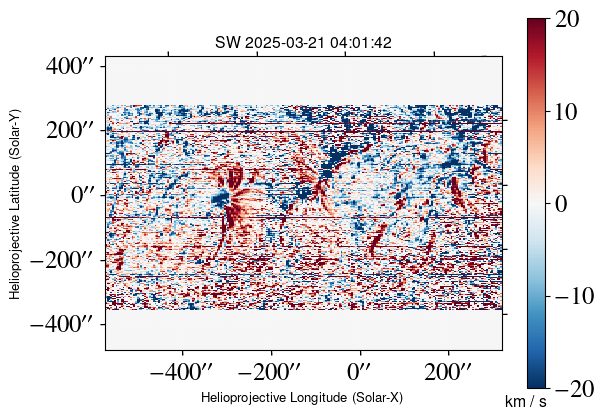

In [ ]:
doppler_map_centered = sunpy.map.Map(doppler_map.data - np.nanmedian(doppler_map.data), doppler_map.meta)
doppler_map_centered.peek(vmin=-20, vmax=20, cmap='RdBu_r', aspect = 0.2)

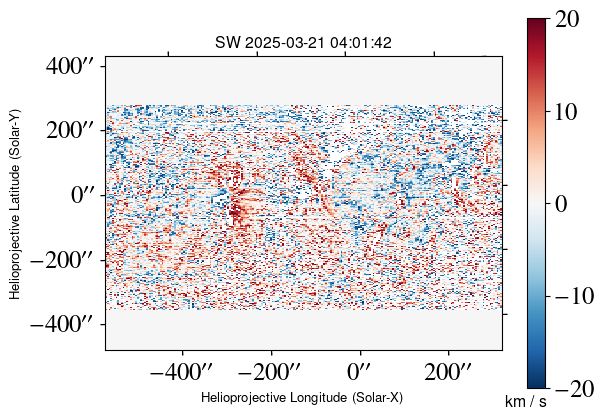

In [ ]:
# Define physical Doppler limits (e.g., ±200 km/s)
vmin, vmax = -20, 20

# Apply mask
value_masked_data = np.where((doppler_map_centered.data > vmin) & (doppler_map_centered.data < vmax),
                             doppler_map_centered.data, np.nan)

# Create new map
value_masked_map = sunpy.map.Map(value_masked_data, doppler_map_centered.meta)

value_masked_map.peek(vmin=-20, vmax=20, cmap='RdBu_r', aspect = 0.2)

In [ ]:
print(mask_clean.shape, value_masked_map.data.shape)


(830, 224) (830, 224)


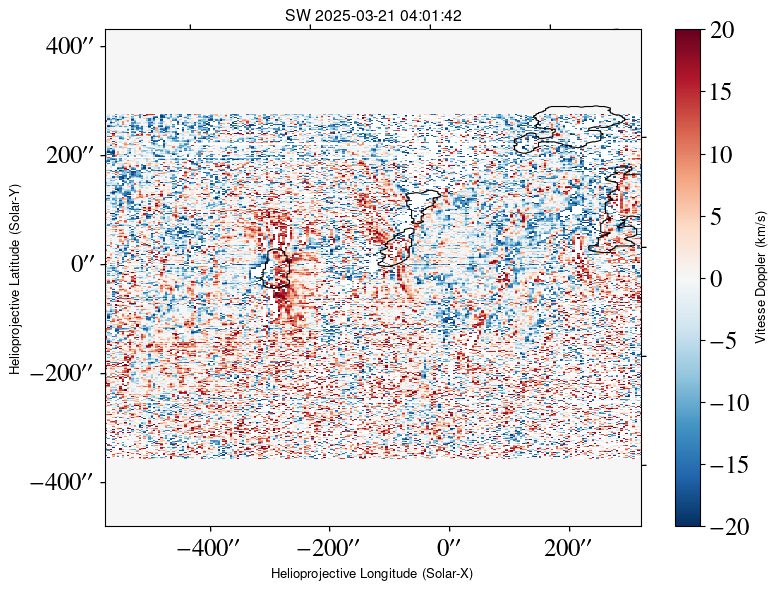

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(projection=value_masked_map)

value_masked_map.plot(
        cmap='RdBu_r', vmin=-20, vmax=20,
        axes=ax,
        aspect=0.25)           # ← même facteur que pour la radiance

ax.contour(mask_clean, levels=[0.5],
           colors='black', linewidths=0.8,
           transform=ax.get_transform('pixel'))

plt.colorbar(ax.images[0], ax=ax, label="Vitesse Doppler (km/s)")
plt.tight_layout()
#plt.savefig('/home/wmouici/stage/data/doppler_map_2103.pdf')
plt.show()


### Contour plot on FSI maps

2025-08-24 16:25:51 - sunpy - WARNING: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.


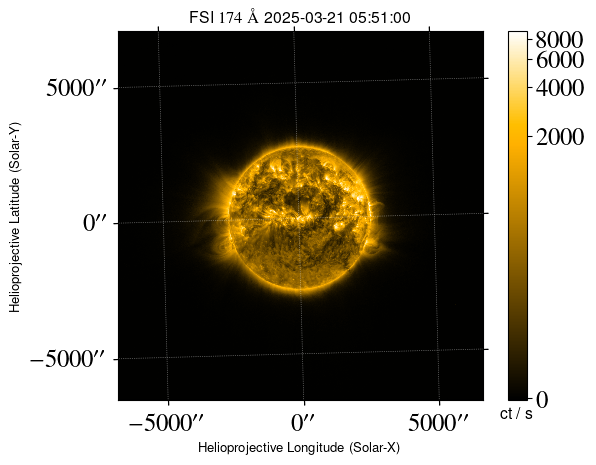

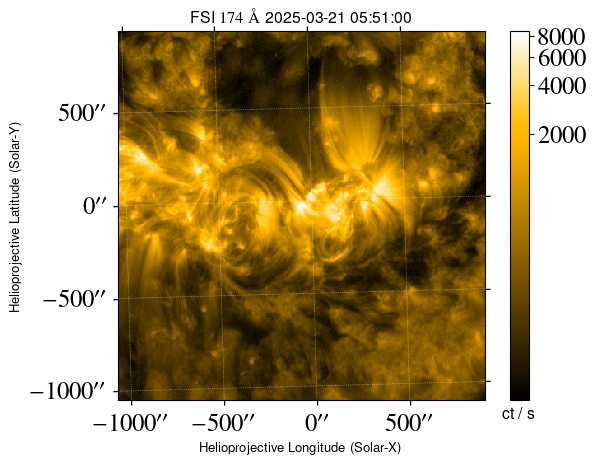

In [ ]:
path_fsi = Path("./solo_L2_eui-fsi174-image_20250321T055055273_V00.fits")
path_hri = Path("../run_saffron/saffron_run_results_corrige/solo_L2.5_spice-n-ras_20250321T040142_V04_318767203-000_0000/00706.02-mg_9.fits")

if True:
     from astropy.io import fits
     from sunpy.map import Map
     fsi_map = Map(path_fsi)
     tmp_path = Path("./tmp/")
     tmp_path.mkdir(exist_ok=True)
     hdul = fits.open(path_hri)
     data = hdul[0].data*hdul[2].data
     map_ = Map([data,hdul[0].header])
     sub_map = to_submap(target_map=fsi_map,source_map=map_,expand=[500,500]*u.arcsec)
     #sub_map.save(tmp_path/path_fsi.name,overwrite=True)
     # map_.save(tmp_path/path_hri.name,overwrite=True)
     # path_hri = str(tmp_path/path_hri.name)
     # path_fsi = str(tmp_path/path_fsi.name)

fsi_map.peek()
sub_map.peek()

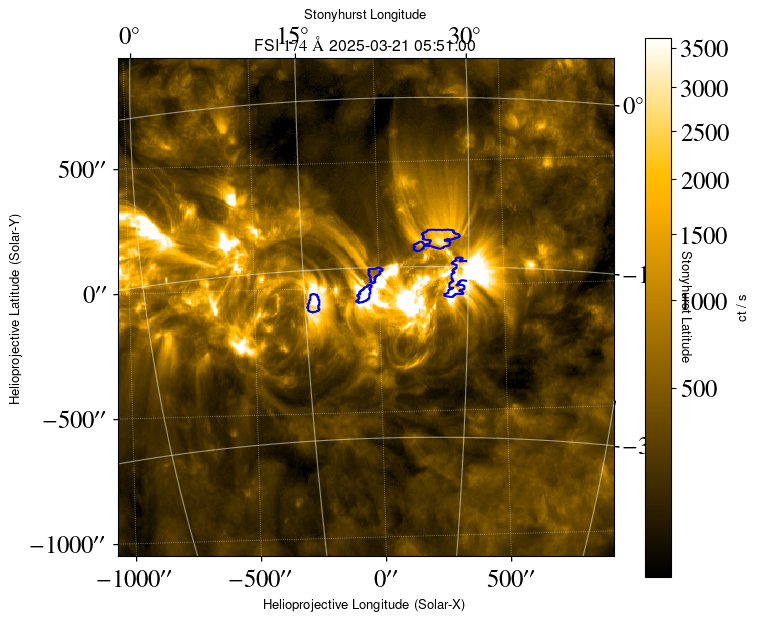

In [ ]:
observer_fsi = sub_map.observer_coordinate
rotated_contours_to_submap = []
for contour in arcsec_contours:
    rotated = solar_rotate_coordinate(contour, observer=observer_fsi)
    rotated_contours_to_submap.append(rotated)


fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(projection=sub_map)

norm = normit(sub_map.data, AsymmetricPercentileInterval(1, 99))

sub_map.plot(axes=ax, cmap='sdoaia171', norm=norm)

sub_map.draw_grid(axes=ax)

for contour in arcsec_contours:
    ax.plot_coord(contour, color='blue', linewidth=1.5)
cbar = plt.colorbar(ax.get_images()[0], ax=ax, pad=0.05)
cbar.set_label(sub_map.unit.to_string())
#plt.savefig("/home/wmouici/stage/data/contours_fsi_2103.pdf")
plt.show()


### Contours plot on AIA map

In [ ]:
if not os.path.exists('aia_map_20250321.fits'):
    import urllib.request
    urllib.request.urlretrieve(
        'http://jsoc2.stanford.edu/data/aia/synoptic/2025/03/21/H0400/AIA20250321_0414_0193.fits',
        'aia_map_20250321.fits')

aia = sunpy.map.Map('aia_map_20250321.fits')
dtime = aia.date

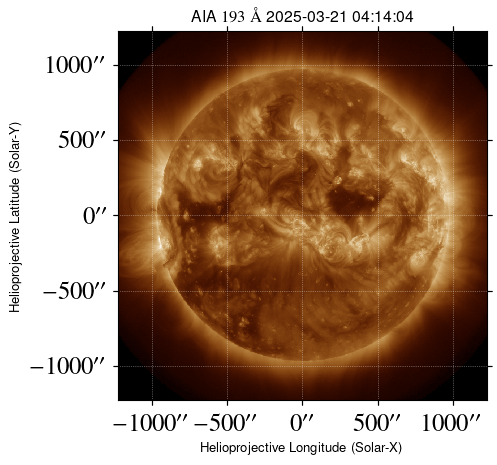

In [ ]:
ax = plt.subplot(1, 1, 1, projection=aia)
aia.plot(axes=ax)

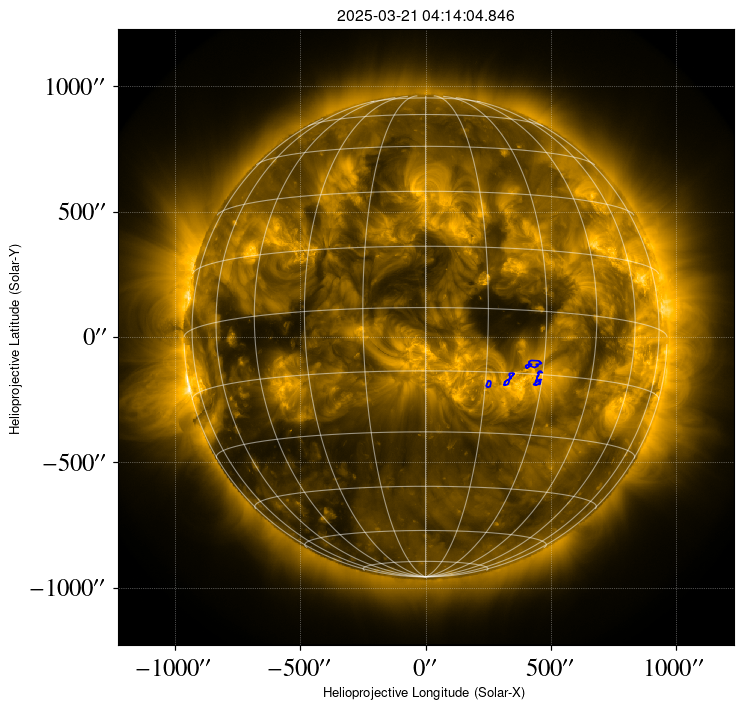

In [ ]:

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection=aia)

aia.plot(axes=ax, cmap='sdoaia171') 
aia.draw_grid(axes=ax)

for contour in arcsec_contours:
    ax.plot_coord(contour, color='blue', linewidth=1.2)

plt.title(f"{aia.date.iso}")
plt.show()

### Run the PFSS on high fip bias region and around

1. Select magnetic field map from gong

In [ ]:
gong_map = sunpy.map.Map('./mrbqs250321t0404c2295_054.fits')

# Patch si les unités ne sont pas dans le header
if 'cunit1' not in gong_map.meta:
    gong_map.meta['cunit1'] = 'deg'
if 'cunit2' not in gong_map.meta:
    gong_map.meta['cunit2'] = 'deg'

In [ ]:
nrho = 25
rss = 2.5
pfss_in = pfsspy.Input(gong_map, nrho, rss)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-08-24 16:26:00 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


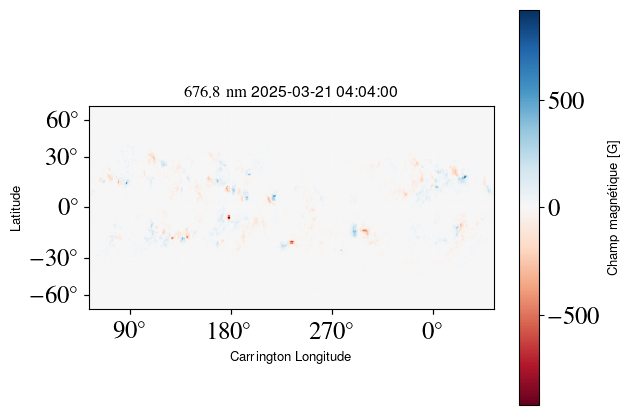

In [ ]:
m = pfss_in.map

fig = plt.figure()
ax = plt.subplot(projection=m)
im = m.plot(axes=ax)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label(f'Champ magnétique [{m.unit}]')

plt.tight_layout()
plt.show()

2. run the pfss

In [ ]:
pfss_out = pfsspy.pfss(pfss_in)

3. selection points in the high-fip bias area and around

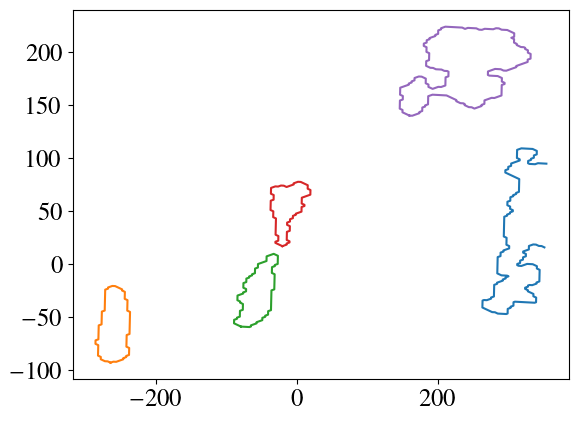

In [ ]:
for contour in arcsec_contours:
    plt.plot(contour.Tx.to_value(u.arcsec),contour.Ty.to_value(u.arcsec))

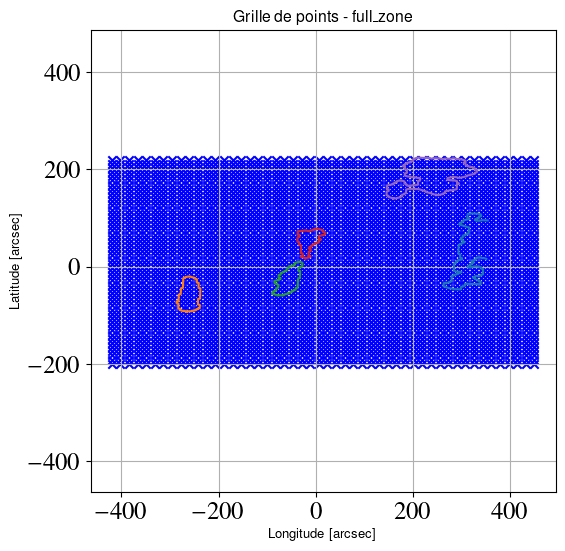

In [ ]:
hp_lon = np.linspace(-420, 450, 50) * u.arcsec
hp_lat = np.linspace(-200, 220, 50) * u.arcsec
lon, lat = np.meshgrid(hp_lon, hp_lat)
full_zone = SkyCoord(lon.ravel(), lat.ravel(),
                 frame=fsi_map.coordinate_frame)
lon_arcsec = full_zone.Tx.to_value(u.arcsec)
lat_arcsec = full_zone.Ty.to_value(u.arcsec)

plt.figure(figsize=(6, 6))
plt.scatter(lon_arcsec, lat_arcsec, marker='x', color='blue')
for contour in arcsec_contours:
    plt.plot(contour.Tx.to_value(u.arcsec), contour.Ty.to_value(u.arcsec))
plt.xlabel("Longitude [arcsec]")
plt.ylabel("Latitude [arcsec]")
plt.title("Grille de points - full_zone")
plt.grid(True)
plt.axis("equal")
plt.show()

/tmp/ipykernel_348040/1570587253.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


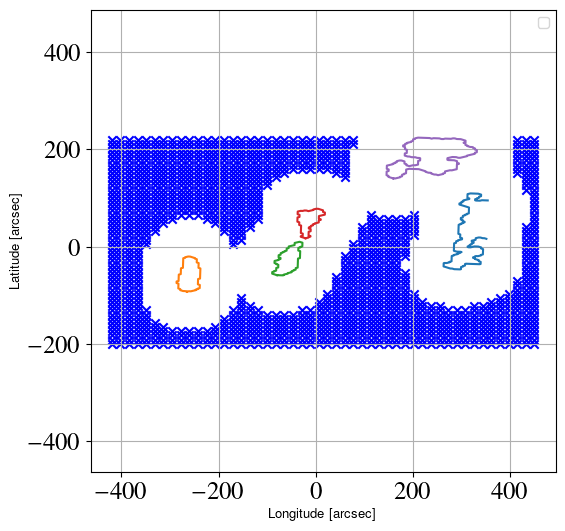

In [ ]:

x = full_zone.Tx.to_value(u.arcsec)
y = full_zone.Ty.to_value(u.arcsec)
points = list(zip(x, y))

buffer = 80
polygons = []
for contour in arcsec_contours:
    coords = list(zip(contour.Tx.to_value(u.arcsec), contour.Ty.to_value(u.arcsec)))
    poly = Polygon(coords).buffer(buffer)
    polygons.append(poly)


points_outside = []
for pt in points:
    point = Point(pt)
    inside = any(poly.contains(point) for poly in polygons)
    if not inside:
        points_outside.append(pt)


x_out, y_out = zip(*points_outside)

plt.figure(figsize=(6, 6))
plt.scatter(x_out, y_out, color='blue', marker='x')
for contour in arcsec_contours:
    plt.plot(contour.Tx.to_value(u.arcsec), contour.Ty.to_value(u.arcsec))
plt.xlabel("Longitude [arcsec]")
plt.ylabel("Latitude [arcsec]")

plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()


/tmp/ipykernel_348040/4294083204.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


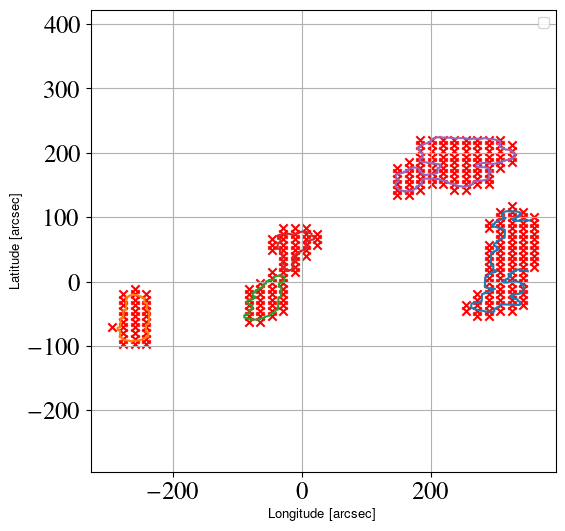

In [ ]:
x = full_zone.Tx.to_value(u.arcsec)
y = full_zone.Ty.to_value(u.arcsec)
points = list(zip(x, y))

buffer = 10 
polygons = []
for contour in arcsec_contours:
    coords = list(zip(contour.Tx.to_value(u.arcsec), contour.Ty.to_value(u.arcsec)))
    poly = Polygon(coords).buffer(buffer)
    polygons.append(poly)

points_inside = []
for pt in points:
    point = Point(pt)
    if any(poly.contains(point) for poly in polygons):
        points_inside.append(pt)

x_in, y_in = zip(*points_inside)

plt.figure(figsize=(6, 6))
plt.scatter(x_in, y_in, color='red', marker='x')
for contour in arcsec_contours:
    plt.plot(contour.Tx.to_value(u.arcsec), contour.Ty.to_value(u.arcsec))
plt.xlabel("Longitude [arcsec]")
plt.ylabel("Latitude [arcsec]")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()


In [ ]:
points_outside_coord = SkyCoord(x_out*u.arcsec, y_out*u.arcsec,frame=fsi_map.coordinate_frame)
points_inside_coord = SkyCoord(x_in * u.arcsec, y_in * u.arcsec, frame=fsi_map.coordinate_frame)


### Choose down here if you want to select points_outside_coord or points_inside_coord in the zone_list

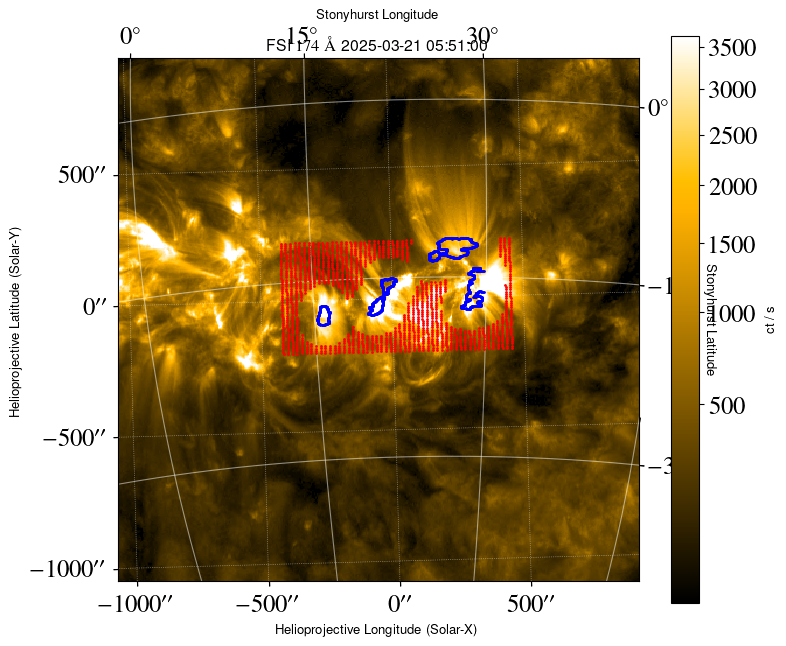

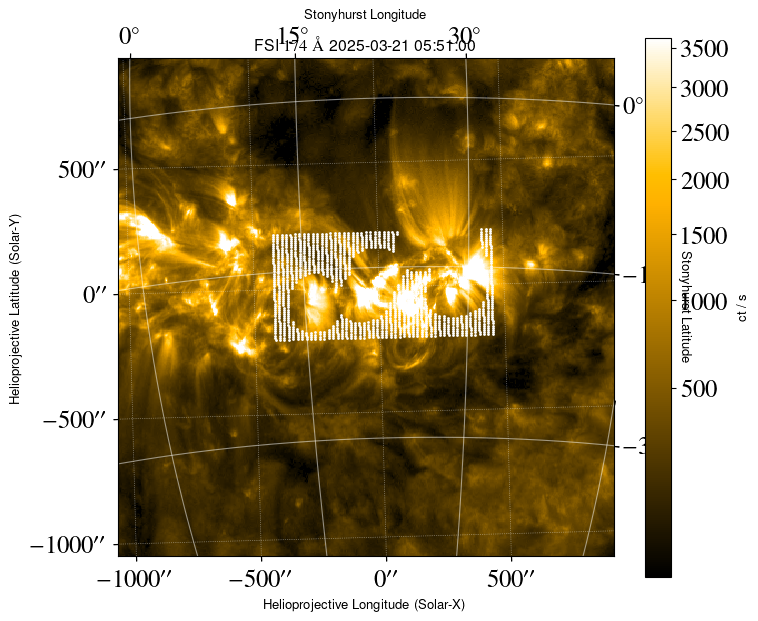

In [ ]:
zone_list = []
for contour in points_outside_coord: #change to points_outside or points_inside
    zone = SkyCoord(contour.Tx, contour.Ty, frame=sub_map.coordinate_frame)
    zone_list.append(zone)

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(projection=sub_map)

norm = normit(sub_map.data, AsymmetricPercentileInterval(1, 99))
sub_map.plot(axes=ax, cmap='sdoaia171', norm=norm)

sub_map.draw_grid(axes=ax)
for zone in zone_list:
    ax.plot_coord(zone, color='red', marker='o', linewidth=0, markersize=1)
for contours in arcsec_contours:
    ax.plot_coord(contours, color='blue', marker='o', linewidth=0, markersize=1)
cbar = plt.colorbar(ax.get_images()[0], ax=ax, pad=0.05)
cbar.set_label(sub_map.unit.to_string())
plt.tight_layout()
plt.show()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-08-24 16:27:22 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


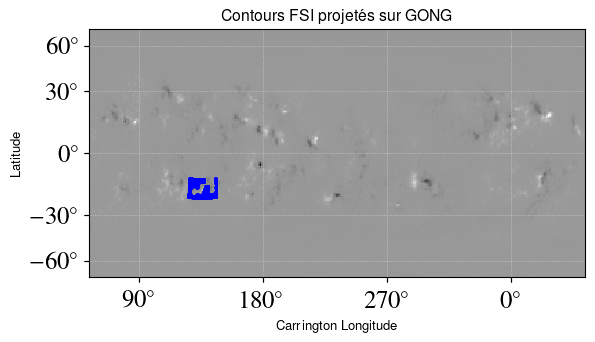

In [ ]:
fig = plt.figure()
ax = plt.subplot(projection=gong_map)
gong_map.plot(axes=ax)
for contour in zone_list:
    coord = SkyCoord(contour.Tx, contour.Ty, frame=fsi_map.coordinate_frame)
    ax.plot_coord(coord, color='blue', linewidth=0, marker='o', markersize=1)

ax.set_title("contours plot on gong map")
plt.show()


In [ ]:
tracer = tracing.FortranTracer()
tracer = tracing.FortranTracer()
flines_list_full = [tracer.trace(zone, pfss_out) for zone in zone_list]

/home/wmouici/envs/SAFFRON/lib/python3.11/site-packages/pfsspy/output.py:95: UserWarning: Could not parse unit string "Gauss" as a valid FITS unit.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards.
  warnings.warn(f'Could not parse unit string "{unit_str}" as a valid FITS unit.\n'
/home/wmouici/envs/SAFFRON/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to auto) and try again.
  warnings.warn(


In [ ]:
expansion_factors_full = []

for fieldline_group in flines_list_full:
    for fl in fieldline_group.field_lines:
        expansion_factors_full.append(fl.expansion_factor)


In [ ]:
print(len(expansion_factors_full))
print(np.sum(np.isnan(expansion_factors_full)))

1258
1258


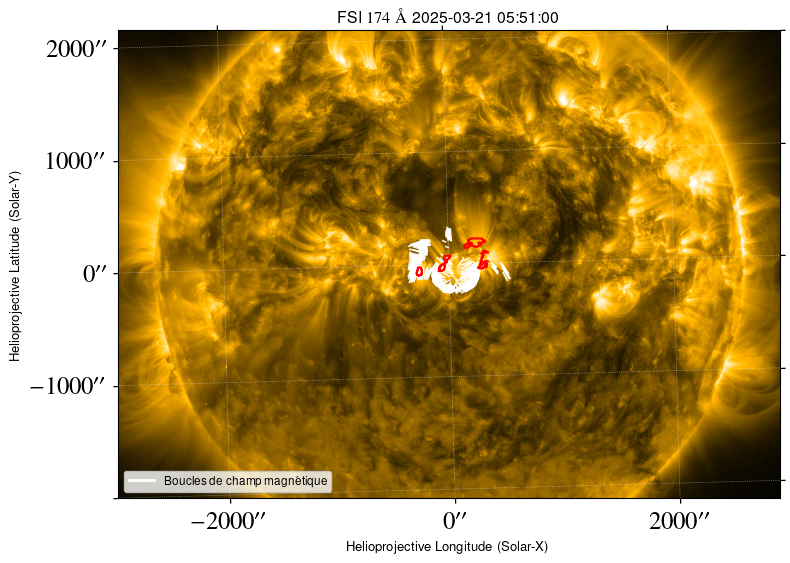

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

min_lon = np.min(arcsec_contours[3].Tx.to_value(u.arcsec))
max_lon = np.max(arcsec_contours[3].Tx.to_value(u.arcsec))

min_la = np.min(arcsec_contours[3].Ty.to_value(u.arcsec))
max_la = np.max(arcsec_contours[3].Ty.to_value(u.arcsec))

x_start = -3000 * u.arcsec
x_end   = 3000 * u.arcsec
y_start = -2000 * u.arcsec
y_end   = 2000 * u.arcsec

bottom_left = SkyCoord(x_start, y_start, frame=fsi_map.coordinate_frame)
top_right = SkyCoord(x_end, y_end, frame=fsi_map.coordinate_frame)
bl_px = fsi_map.wcs.world_to_pixel(bottom_left)
tr_px = fsi_map.wcs.world_to_pixel(top_right)

plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1, projection=fsi_map)
fsi_map.plot(axes=ax)

ax.set_xlim(bl_px[0], tr_px[0])
ax.set_ylim(bl_px[1], tr_px[1])

for flines in flines_list_full:
    for fl in flines.field_lines:
        if fl.coords is None or fl.coords.shape[0] == 0:
            continue  
        color = 'black' if fl.is_open else 'white'
        ax.plot_coord(fl.coords, color=color, linewidth=1.2, alpha=0.9)

for contour in arcsec_contours:
    ax.plot_coord(contour, color='red', linewidth=1.5)
legend_elements = [
    Line2D([0], [0], color='white', lw=2, label=' Boucles de champ magnétique'),
]

ax.legend(handles=legend_elements, loc='lower left', fontsize=9)
plt.tight_layout()
plt.show()

### Plot des FOV

2025-08-24 16:30:02 - sunpy - WARNING: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.


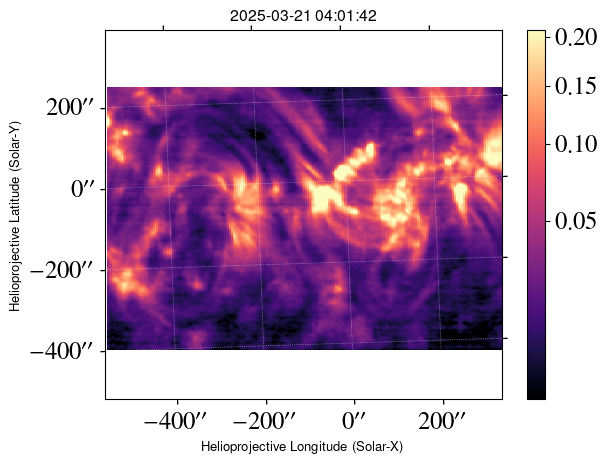

In [ ]:
raster = SPICEL3Raster(folder_path="../run_saffron/saffron_run_results_corrige/solo_L2.5_spice-n-ras_20250321T040142_V04_318767203-000_0600")
radiance_mg = raster.find_line(706).get_map("rad",remove_dumbells=True)
norm = astropy.visualization.mpl_normalize.ImageNormalize(radiance_mg.data,
                      interval=AsymmetricPercentileInterval(1, 99),
                      stretch=astropy.visualization.SqrtStretch()
                     )
radiance_mg.plot_settings['cmap'] = plt.get_cmap('magma')
radiance_mg.plot_settings['norm'] = norm
radiance_mg.plot(norm=norm, aspect='auto')
plt.colorbar()

2025-08-24 16:30:03 - sunpy - WARNING: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.


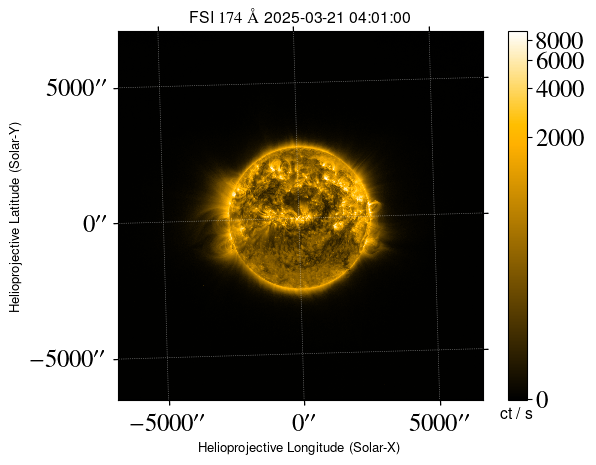

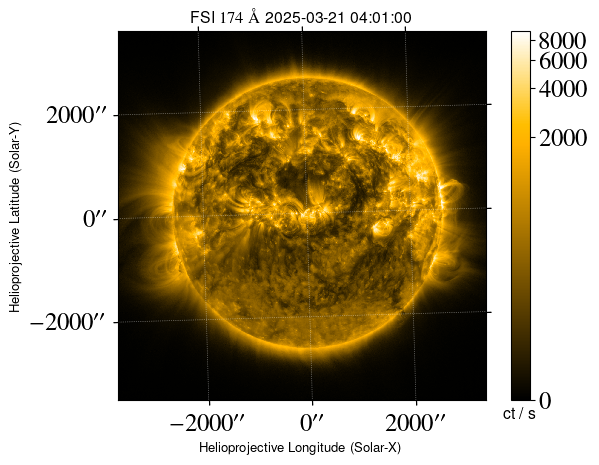

In [ ]:
path_fsi = Path("./solo_L2_eui-fsi174-image_20250321T055055273_V00.fits")
path_hri = Path("../run_saffron/saffron_run_results_corrige/solo_L2.5_spice-n-ras_20250321T040142_V04_318767203-000_0000/00706.02-mg_9.fits")
if True:
     from astropy.io import fits
     from sunpy.map import Map
     fsi_map = Map(path_fsi)
     
     tmp_path = Path("./tmp/")
     tmp_path.mkdir(exist_ok=True)
     hdul = fits.open(path_hri)
     data = hdul[0].data*hdul[2].data
     map_ = Map([data,hdul[0].header])
     sub_map_bis = to_submap(target_map=fsi_map,source_map=map_,expand=[3000,3000]*u.arcsec)
     #sub_map.save(tmp_path/path_fsi.name,overwrite=True)
     # map_.save(tmp_path/path_hri.name,overwrite=True)
     # path_hri = str(tmp_path/path_hri.name)
     # path_fsi = str(tmp_path/path_fsi.name)

fsi_map.peek()
sub_map_bis.peek()

In [ ]:
path_fsi = Path("./solo_L2_eui-fsi174-image_20250321T055055273_V00.fits")
path_hri = Path("../run_saffron/saffron_run_results_corrige/solo_L2.5_spice-n-ras_20250321T040142_V04_318767203-000_0000/00706.02-mg_9.fits")
fsi_map = Map(path_fsi)

In [ ]:
def rotate_coords(mmap, rtime):
    bl = SkyCoord(mmap.bottom_left_coord.Tx, mmap.bottom_left_coord.Ty, frame=mmap.coordinate_frame)
    tr = SkyCoord(mmap.top_right_coord.Tx, mmap.top_right_coord.Ty, frame=mmap.coordinate_frame)

    bl_diff = sunpy.coordinates.metaframes.RotatedSunFrame(base=bl, rotated_time=rtime)
    tr_diff = sunpy.coordinates.metaframes.RotatedSunFrame(base=tr, rotated_time=rtime)

    bl_diffrot = bl_diff.transform_to(mmap.coordinate_frame)
    tr_diffrot = tr_diff.transform_to(mmap.coordinate_frame)

    bl = SkyCoord(bl_diffrot.Tx.value, bl_diffrot.Ty.value, frame=mmap.coordinate_frame, unit=u.arcsec)
    tr = SkyCoord(tr_diffrot.Tx.value, tr_diffrot.Ty.value, frame=mmap.coordinate_frame, unit=u.arcsec)

    return bl, tr


In [ ]:
spice_bl, spice_tr = rotate_coords(radiance_mg, rtime=aia.date)
eui_fsi_map_bl, eui_fsi_map_tr = rotate_coords(fsi_map, rtime=aia.date)

2025-08-24 16:30:06 - sunpy - WARNING: SunpyUserWarning: The conversion of these 2D helioprojective coordinates to 3D is all NaNs because off-disk coordinates need an additional assumption to be mapped to calculate distance from the observer. Consider using the context manager `Helioprojective.assume_spherical_screen()`.


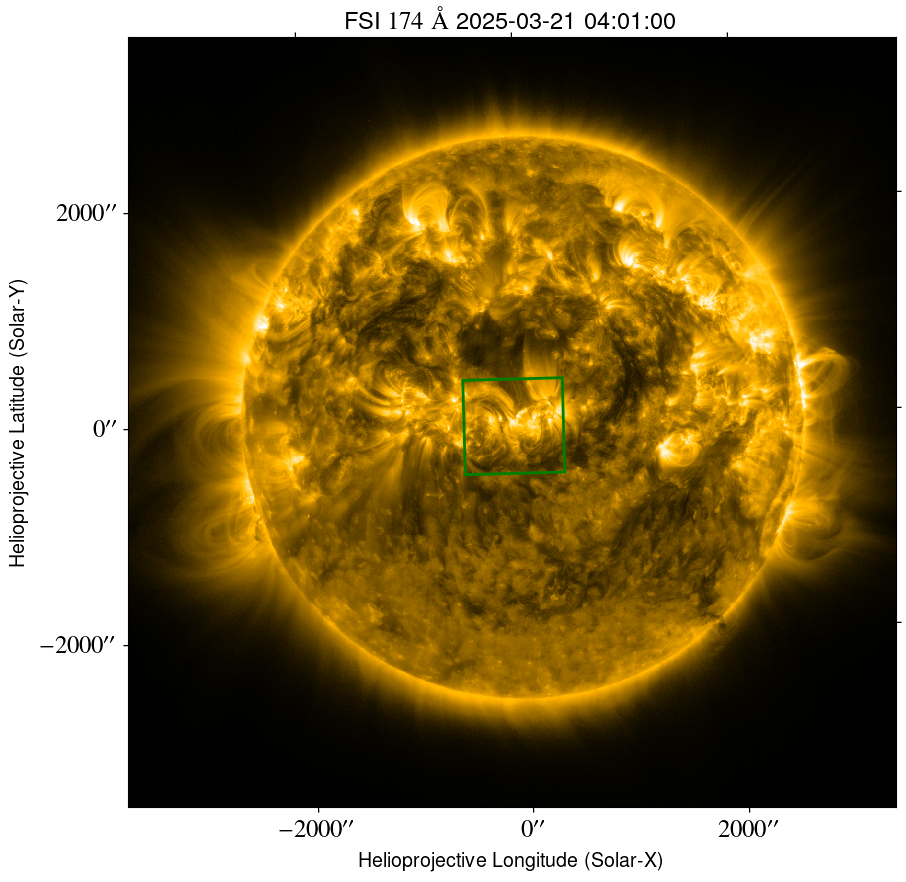

In [ ]:
# Plot the FOVs of EUI/HRI, PHI/HRT, and SPICE on AIA 193 map
plt.rc("font",size=15)
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(111, projection=sub_map_bis)
ax1.grid(False)
sub_map_bis.plot(axes=ax1, clip_interval=(1, 99.99)*u.percent)

radiance_mg.draw_quadrangle(spice_bl, top_right=spice_tr, axes=ax1, edgecolor='green', lw=2)
#fsi_map.draw_quadrangle(eui_fsi_map_bl, top_right=eui_fsi_map_tr, axes=ax1, edgecolor='blue', lw=2)
ax1.grid(False)

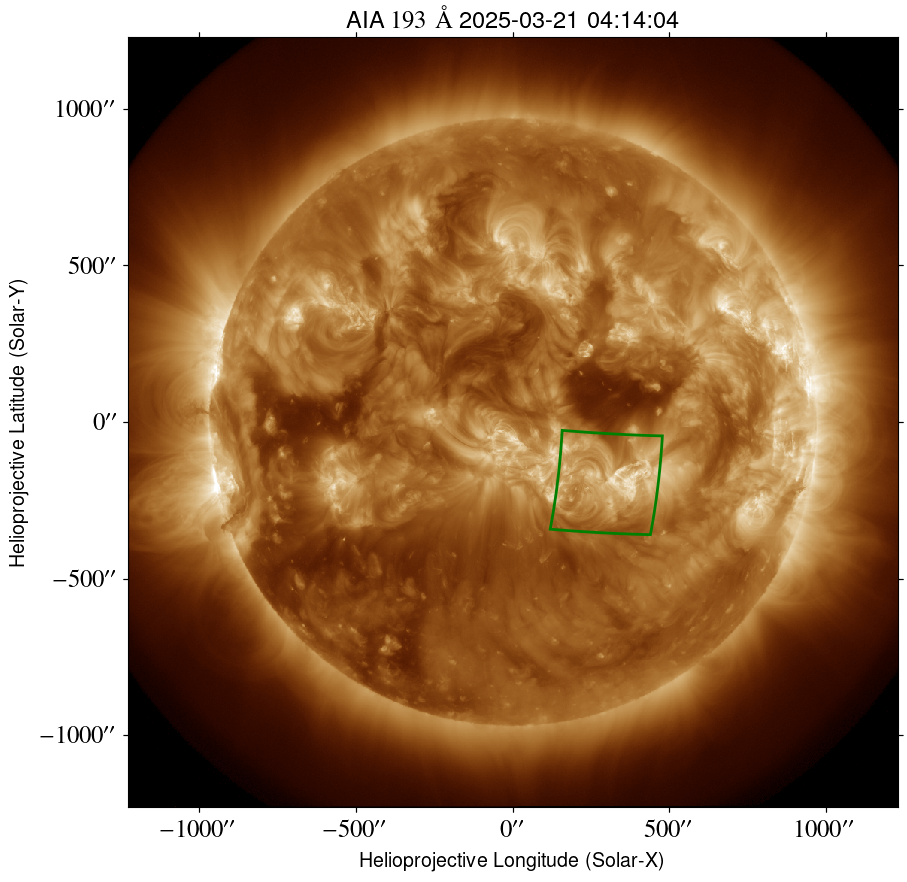

In [ ]:
plt.rc("font",size=15)
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(111, projection=aia)
ax1.grid(False)
aia.plot(axes=ax1, clip_interval=(1, 99.99)*u.percent)

radiance_mg.draw_quadrangle(spice_bl, top_right=spice_tr, axes=ax1, edgecolor='green', lw=2)
fsi_map.draw_quadrangle(eui_fsi_map_bl, top_right=eui_fsi_map_tr, axes=ax1, edgecolor='black', lw=2)
ax1.grid(False)